In [1]:
import itertools

import cirq
import numpy as np
from cirq.experiments import random_quantum_circuit_generation as rqcg

In [2]:
# Random single qubit gates
exponents = np.linspace(0, 7/4, 8)
SINGLE_QUBIT_GATES = [
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
]

In [5]:
q0, q1 = cirq.LineQubit.range(2)
MAX_DEPTH = 100
N_CIRCUITS = 10
circuits = [
    rqcg.random_rotations_between_two_qubit_circuit(
        q0, q1,
        depth=MAX_DEPTH,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b),
        single_qubit_gates=SINGLE_QUBIT_GATES)
    for _ in range(N_CIRCUITS)
]
cycle_depths = np.arange(1, MAX_DEPTH + 1, 9)


In [6]:
pure_sim = cirq.Simulator()

# Pauli Error. If there is an error, it is either X, Y, or Z
# with probability E_PAULI / 3
E_PAULI = 5e-3
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(E_PAULI))

# These two qubit circuits have 2^2 = 4 probabilities
DIM = 4

records = []
for cycle_depth in cycle_depths:
    for circuit_i, circuit in enumerate(circuits):

        # Truncate the long circuit to the requested cycle_depth
        circuit_depth = cycle_depth * 2 + 1
        assert circuit_depth <= len(circuit)
        trunc_circuit = circuit[:circuit_depth]

        # Pure-state simulation
        psi = pure_sim.simulate(trunc_circuit).final_state_vector
        pure_probs = np.abs(psi)**2

        # Noisy execution
        meas_circuit = trunc_circuit + cirq.measure(q0, q1)
        sampled_inds = noisy_sim.sample(meas_circuit, repetitions=10_000).values[:,0]
        sampled_probs = np.bincount(sampled_inds, minlength=DIM) / len(sampled_inds)

        # Save the results
        records += [{
            'circuit_i': circuit_i,
            'cycle_depth': cycle_depth,
            'circuit_depth': circuit_depth,
            'pure_probs': pure_probs,
            'sampled_probs': sampled_probs,
        }]
        print('.', end='', flush=True)


........................................................................................................................

In [10]:
for record in records:
    e_u = np.sum(record['pure_probs']**2)
    u_u = np.sum(record['pure_probs']) / DIM
    m_u = np.sum(record['pure_probs'] * record['sampled_probs'])
    record.update(
        e_u=e_u,
        u_u=u_u,
        m_u=m_u,
    )


In [11]:
import pandas as pd
df = pd.DataFrame(records)
df['y'] = df['m_u'] - df['u_u']
df['x'] = df['e_u'] - df['u_u']

df['numerator'] = df['x'] * df['y']
df['denominator'] = df['x'] ** 2
df.head()


,circuit_i,cycle_depth,circuit_depth,pure_probs,sampled_probs,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,3,"[0.28661165, 0.4633883, 0.21338831, 0.03661164]","[0.2879, 0.4543, 0.2144, 0.0434]",0.34375,0.25,0.340372,0.090372,0.09375,0.008472,0.008789
1,1,1,3,"[2.220446e-16, 0.24999997, 0.24999997, 0.4999999]","[0.0055, 0.252, 0.2491, 0.4934]",0.37500,0.25,0.371975,0.121975,0.12500,0.015247,0.015625
2,2,1,3,"[0.12499998, 0.12499999, 0.72855324, 0.021446602]","[0.1362, 0.1273, 0.704, 0.0325]",0.56250,0.25,0.546536,0.296536,0.31250,0.092667,0.097656
3,3,1,3,"[0.64016503, 0.21338831, 0.109834954, 0.036611...","[0.6307, 0.22, 0.11, 0.0393]",0.46875,0.25,0.464218,0.214218,0.21875,0.046860,0.047852
4,4,1,3,"[0.036611646, 0.21338834, 0.46338835, 0.28661165]","[0.042, 0.2148, 0.4582, 0.285]",0.34375,0.25,0.341382,0.091382,0.09375,0.008567,0.008789


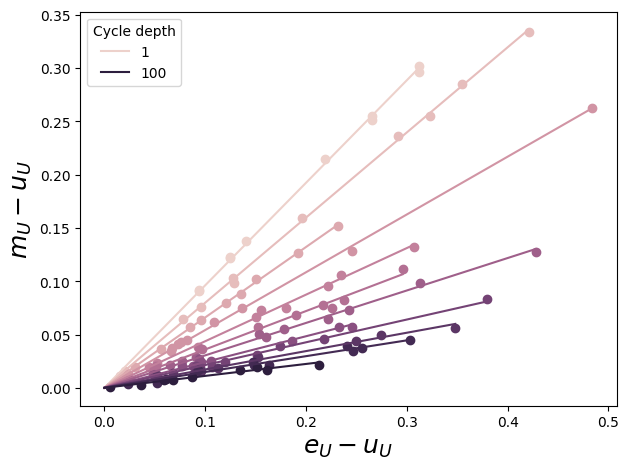

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

# Color by cycle depth
import seaborn as sns
colors = sns.cubehelix_palette(n_colors=len(cycle_depths))
colors = {k: colors[i] for i, k in enumerate(cycle_depths)}

_lines = []
def per_cycle_depth(df):
    fid_lsq = df['numerator'].sum() / df['denominator'].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df['x'].max())
    l, = plt.plot(xx, fid_lsq*xx, color=colors[cycle_depth])
    plt.scatter(df['x'], df['y'], color=colors[cycle_depth])

    global _lines
    _lines += [l] # for legend
    return pd.Series({'fidelity': fid_lsq})

fids = df.groupby('cycle_depth').apply(per_cycle_depth).reset_index()
plt.xlabel(r'$e_U - u_U$', fontsize=18)
plt.ylabel(r'$m_U - u_U$', fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0,-1]], cycle_depths[[0,-1]], loc='best', title='Cycle depth')
plt.tight_layout()


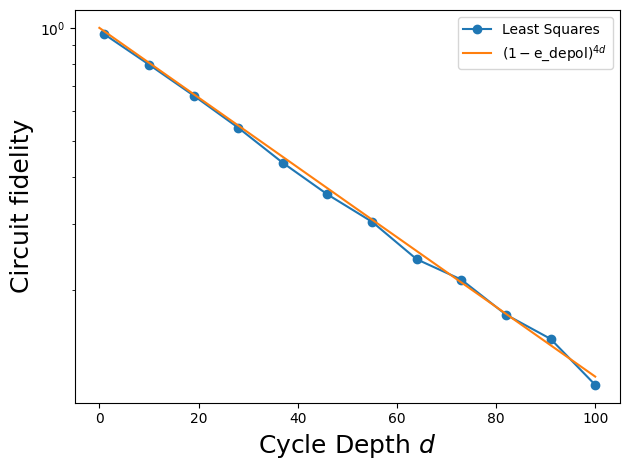

In [15]:
plt.plot(
    fids['cycle_depth'],
    fids['fidelity'],
    marker='o',
    label='Least Squares')

xx = np.linspace(0, fids['cycle_depth'].max())

# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
e_depol = E_PAULI / (1 - 1/DIM**2)

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).
plt.plot(xx, (1-e_depol)**(4*xx), label=r'$(1-\mathrm{e\_depol})^{4d}$')

plt.ylabel('Circuit fidelity', fontsize=18)
plt.xlabel('Cycle Depth $d$', fontsize=18)
plt.legend(loc='best')
plt.yscale('log')
plt.tight_layout()


In [16]:
from cirq.experiments.xeb_fitting import fit_exponential_decays

# Ordinarily, we'd use this function to fit curves for multiple pairs.
# We add our qubit pair as a column.
fids['pair'] = [(q0, q1)] * len(fids)

fit_df = fit_exponential_decays(fids)
fit_row = fit_df.iloc[0]
print(f"Noise model fidelity: {(1-e_depol)**4:.3e}")
print(f"XEB layer fidelity:   {fit_row['layer_fid']:.3e} +- {fit_row['layer_fid_std']:.2e}")


Noise model fidelity: 9.788e-01
XEB layer fidelity:   9.788e-01 +- 1.74e-04
